In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import numpy as np
from datasets import load_dataset
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from utils_display import pc

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pc('Device', device)

Device: cuda


# Dataset

In [4]:
dataset = load_dataset('squad')
print(dataset['train'][0])

{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}


# Model

In [5]:
model_checkpoint = 'bert-large-uncased-whole-word-masking-finetuned-squad'
model = BertForQuestionAnswering.from_pretrained(model_checkpoint).to(device)
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
sample_index = 1234
question = dataset['train'][sample_index]['question']
context = dataset['train'][sample_index]['context']

answer = dataset['train'][sample_index]['answers']['text'][0]
answer_start = dataset['train'][sample_index]['answers']['answer_start'][0]
answer_end = answer_start + len(answer)

pc('Question', question)
pc('Context', context)
pc('Answer', answer)
pc('Answer start logit', answer_start)
pc('Answer end logit', answer_end)

Question: What will always be restricted in terms of a perpetrator's intent to destroy?
Context: In paragraph 13 the judges raise the issue of the perpetrators' access to the victims: "The historical examples of genocide also suggest that the area of the perpetrators’ activity and control, as well as the possible extent of their reach, should be considered. ... The intent to destroy formed by a perpetrator of genocide will always be limited by the opportunity presented to him. While this factor alone will not indicate whether the targeted group is substantial, it can—in combination with other factors—inform the analysis."
Answer: the opportunity presented to him
Answer start logit: 351
Answer end logit: 383


# Tokenization

In [7]:
batch_encoding_tmp = tokenizer.encode_plus(text=question, text_pair=context)
input_ids = batch_encoding_tmp['input_ids']
attention_mask = batch_encoding_tmp['attention_mask']
pc('Number of tokens in the input', len(input_ids))
pc('IDs', input_ids)
pc('Attention mask', attention_mask)

Number of tokens in the input: 125
IDs: [101, 2054, 2097, 2467, 2022, 7775, 1999, 3408, 1997, 1037, 2566, 22327, 16259, 1005, 1055, 7848, 2000, 6033, 1029, 102, 1999, 20423, 2410, 1996, 6794, 5333, 1996, 3277, 1997, 1996, 27675, 1005, 3229, 2000, 1996, 5694, 1024, 1000, 1996, 3439, 4973, 1997, 14052, 2036, 6592, 2008, 1996, 2181, 1997, 1996, 27675, 1521, 4023, 1998, 2491, 1010, 2004, 2092, 2004, 1996, 2825, 6698, 1997, 2037, 3362, 1010, 2323, 2022, 2641, 1012, 1012, 1012, 1012, 1996, 7848, 2000, 6033, 2719, 2011, 1037, 2566, 22327, 16259, 1997, 14052, 2097, 2467, 2022, 3132, 2011, 1996, 4495, 3591, 2000, 2032, 1012, 2096, 2023, 5387, 2894, 2097, 2025, 5769, 3251, 1996, 9416, 2177, 2003, 6937, 1010, 2009, 2064, 1517, 1999, 5257, 2007, 2060, 5876, 1517, 12367, 1996, 4106, 1012, 1000, 102]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [8]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)
pc('Number of tokens in the input', len(tokens))
pc('Tokens', tokens)

Number of tokens in the input: 125
Tokens: ['[CLS]', 'what', 'will', 'always', 'be', 'restricted', 'in', 'terms', 'of', 'a', 'per', '##pet', '##rator', "'", 's', 'intent', 'to', 'destroy', '?', '[SEP]', 'in', 'paragraph', '13', 'the', 'judges', 'raise', 'the', 'issue', 'of', 'the', 'perpetrators', "'", 'access', 'to', 'the', 'victims', ':', '"', 'the', 'historical', 'examples', 'of', 'genocide', 'also', 'suggest', 'that', 'the', 'area', 'of', 'the', 'perpetrators', '’', 'activity', 'and', 'control', ',', 'as', 'well', 'as', 'the', 'possible', 'extent', 'of', 'their', 'reach', ',', 'should', 'be', 'considered', '.', '.', '.', '.', 'the', 'intent', 'to', 'destroy', 'formed', 'by', 'a', 'per', '##pet', '##rator', 'of', 'genocide', 'will', 'always', 'be', 'limited', 'by', 'the', 'opportunity', 'presented', 'to', 'him', '.', 'while', 'this', 'factor', 'alone', 'will', 'not', 'indicate', 'whether', 'the', 'targeted', 'group', 'is', 'substantial', ',', 'it', 'can', '—', 'in', 'combination', '

In [9]:
def get_segment_ids_from_input_ids(input_ids=input_ids, tokenizer=tokenizer):
    # input:  '[CLS]', 'x', 'x', '[SEP]', 'x', 'x', 'x', 'x', 'x', '[SEP]'
    # output: [0,       0,   0,   0,       1,   1,   1,   1,   1,   1] 
    separator_index = input_ids.index(tokenizer.sep_token_id)
    length_of_first_segment = separator_index + 1
    length_of_second_segment = len(input_ids) - length_of_first_segment
    segment_ids = [0]*length_of_first_segment + [1]*length_of_second_segment    
    return segment_ids

In [10]:
segment_ids = get_segment_ids_from_input_ids(input_ids=input_ids, tokenizer=tokenizer)

for i, (segment_id, token, input_id) in enumerate(zip(segment_ids, tokens, input_ids)):
    print('{:<3} {} {:<16} {:>6,}'.format(i, segment_id, token, input_id))

0   0 [CLS]               101
1   0 what              2,054
2   0 will              2,097
3   0 always            2,467
4   0 be                2,022
5   0 restricted        7,775
6   0 in                1,999
7   0 terms             3,408
8   0 of                1,997
9   0 a                 1,037
10  0 per               2,566
11  0 ##pet            22,327
12  0 ##rator          16,259
13  0 '                 1,005
14  0 s                 1,055
15  0 intent            7,848
16  0 to                2,000
17  0 destroy           6,033
18  0 ?                 1,029
19  0 [SEP]               102
20  1 in                1,999
21  1 paragraph        20,423
22  1 13                2,410
23  1 the               1,996
24  1 judges            6,794
25  1 raise             5,333
26  1 the               1,996
27  1 issue             3,277
28  1 of                1,997
29  1 the               1,996
30  1 perpetrators     27,675
31  1 '                 1,005
32  1 access            3,229
33  1 to  

# Inference

In [11]:
question_answering_model_output_tmp = model(
    torch.tensor([input_ids]).to(device),
    token_type_ids=torch.tensor([segment_ids]).to(device))

start_logits = question_answering_model_output_tmp['start_logits'][0].detach().cpu().numpy()
end_logits = question_answering_model_output_tmp['end_logits'][0].detach().cpu().numpy()

pc('Start logits', start_logits)
pc('End logits', end_logits)

Start logits: [-6.455617   -2.6088524  -8.952436   -8.602486   -8.470135   -4.534412
 -7.558693   -7.0941405  -7.8761063  -8.360671   -8.415267   -8.647873
 -8.830165   -7.0459533  -8.589337   -8.001633   -8.477953   -8.237767
 -9.927114   -6.4555845  -6.809899   -5.8101263  -6.1294     -7.21969
 -5.992236   -7.3683267  -6.767557   -5.749814   -7.2180057  -4.3359594
 -3.7515247  -7.046527   -3.1106515  -7.189594   -6.547542   -4.1976037
 -7.1224885  -5.768374   -5.5914187  -5.3729606  -6.134656   -7.446104
 -4.254991   -7.570479   -6.6222577  -6.9139132  -4.9161434  -4.6120124
 -7.256025   -6.517123   -5.9686394  -7.9121842  -5.714231   -7.7652454
 -5.2690682  -7.8601193  -7.4617386  -7.692283   -8.294041   -6.009706
 -5.0308785  -5.625625   -7.9758086  -6.9527726  -5.8091903  -8.2883415
 -7.349356   -8.059874   -7.047483   -6.9828963  -5.864401   -6.98377
 -6.0199356   0.52014416 -0.17691581 -3.1112723  -2.4034555  -4.759327
 -5.9865046  -2.2112548  -2.8053403  -5.0453973  -4.556302  

# Results

In [12]:
answer_start = np.argmax(start_logits)
answer_end = np.argmax(end_logits)
answer = ' '.join(tokens[answer_start:answer_end+1])

pc('Answer', answer)

Answer: the opportunity presented to him


In [13]:
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{} {:>3}'.format(token, i))

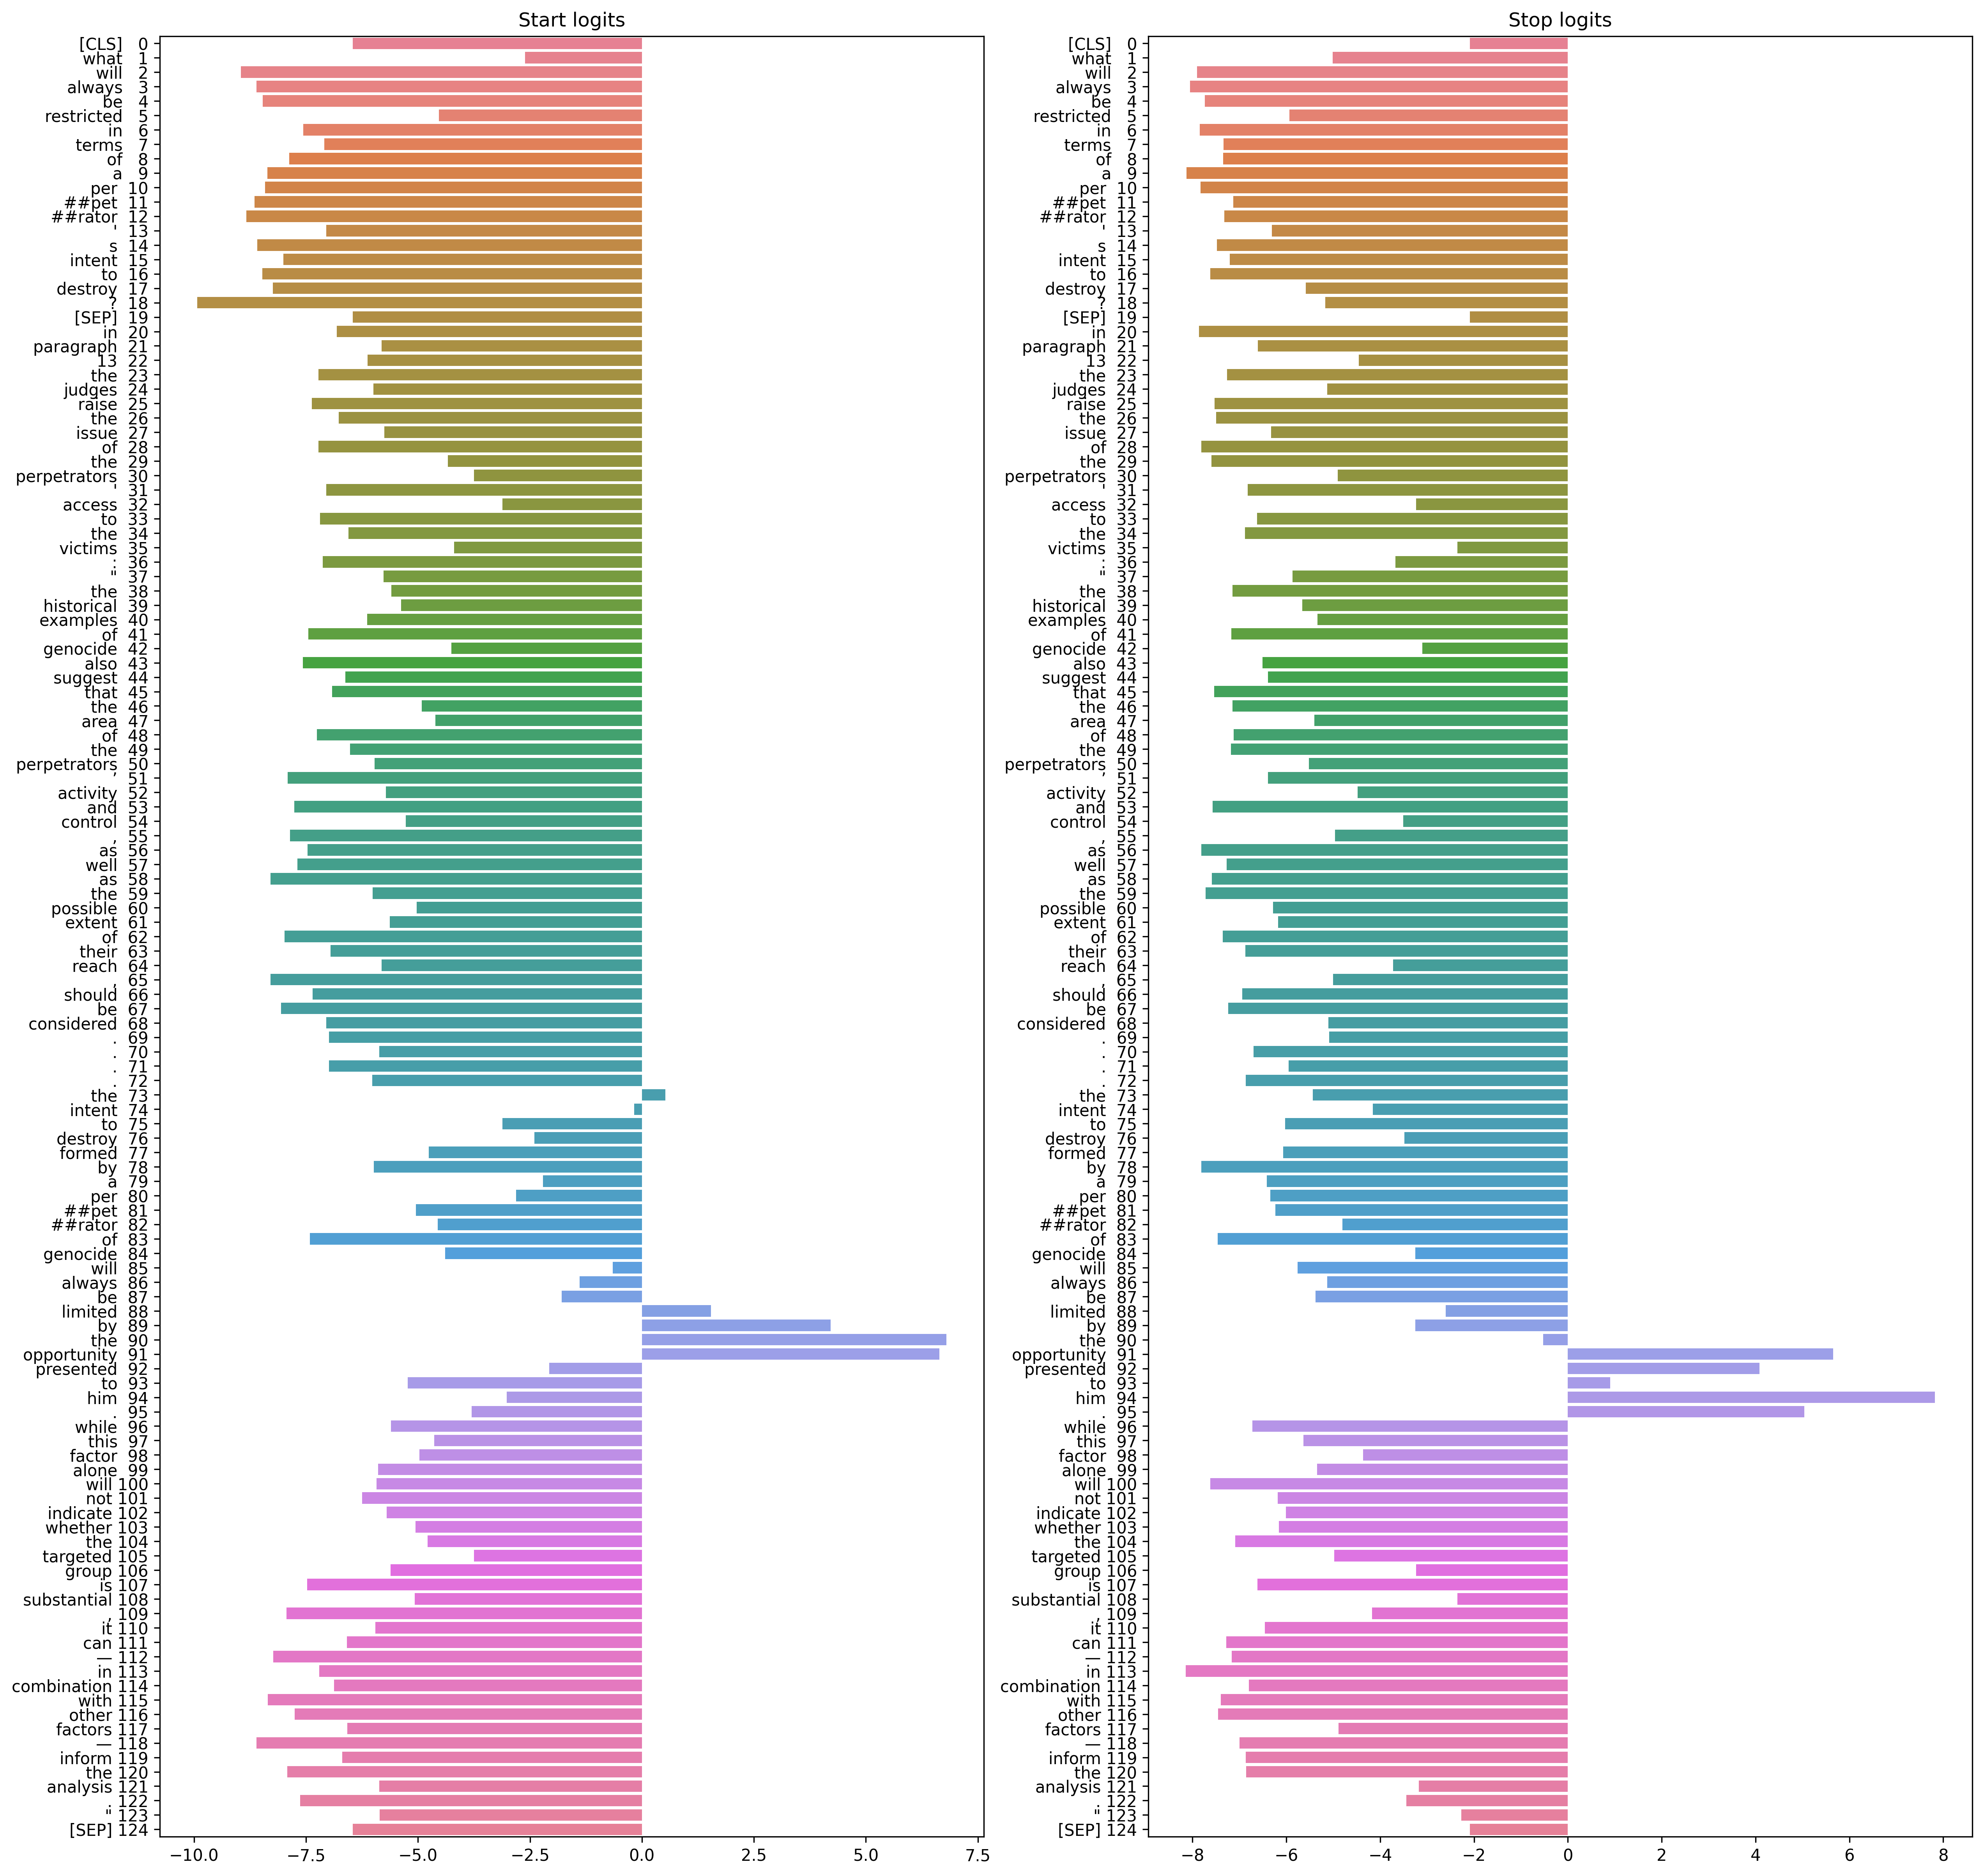

In [14]:
fig, ax = plt.subplots(1, 2)
fig.set_dpi(300)
fig.set_size_inches(20, 20, forward=True)

sns.color_palette("flare")

axx = ax[0]
fig.sca(axx)
axx = sns.barplot(x=start_logits, y=token_labels, hue=token_labels, legend=False)
plt.title("Start logits")

axx = ax[1]
fig.sca(axx)
axx = sns.barplot(x=end_logits, y=token_labels, hue=token_labels, legend=False)
plt.title("Stop logits")

plt.show()